# Deep Learning -CNN

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-05-30 02:49:23.096001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748573363.282951      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748573363.334819      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/dataset1/D1.csv")

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (52681, 3)


In [4]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())



Status Value Counts before resampling:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [5]:
# Define a function to resample the dataset for class balancing
def resample_data(data):
    # Find the maximum count among all statuses
    max_count = data['status'].value_counts().max()
    
    # Initialize an empty DataFrame to store resampled data
    resampled_data = pd.DataFrame()
    
    # Loop through each unique status and resample if needed
    for status in data['status'].unique():
        subset = data[data['status'] == status]
        if len(subset) < max_count:
            # Resample with replacement to match the maximum count
            subset_resampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
            resampled_data = pd.concat([resampled_data, subset_resampled])
        else:
            resampled_data = pd.concat([resampled_data, subset])
    
    return resampled_data

In [6]:
# Apply the resampling function to balance the classes
df = resample_data(df)

In [7]:
# Verify the resampled data
print("\nStatus Value Counts after resampling:")
print(df['status'].value_counts())
print("\nShape of resampled data:", df.shape)



Status Value Counts after resampling:
status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar                 16343
Personality disorder    16343
Name: count, dtype: int64

Shape of resampled data: (114401, 3)


In [8]:
# Check for duplicate rows
duplicates_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates_count)


Number of duplicate rows: 69474


In [9]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['statement'] = df['statement'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['statement'].head())



Sample preprocessed text:
52349    must find something wrong relationship girlfri...
52697    water slide going sound stupid lol basically g...
34039    insomnia last month suddenly developed worst c...
34473    tired wasting money time know nothing wrong im...
34309    head nodding tic cause long term damage hey iv...
Name: statement, dtype: object


In [10]:
# Splitting Data and Encoding Labels
X = df['statement'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (91520,) (91520, 7)
Testing set shape: (22881,) (22881, 7)


In [11]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)


Padded Training Data Shape: (91520, 100)
Padded Testing Data Shape: (22881, 100)


In [12]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model.")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  # Typically 300
print("Download complete. Embedding dimension:", embedding_dim)

[================----------------------------------] 32.5% 541.1/1662.8MB downloadedDownload complete. Embedding dimension: 300


In [13]:
# Building the Embedding Matrix (with Fine-Tuning Enabled)
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")


Found embeddings for 26005 out of 50000 words.


In [14]:
# Building the Enhanced CNN Model (Stacked Convolutions with Residual‐Inspired Flow)
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix],
                    trainable=True))
# Regularize embeddings
model.add(SpatialDropout1D(0.3))

# First Convolutional Block
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Convolutional Block (stacked)
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())

# Global Pooling to collapse the time dimension
model.add(GlobalMaxPooling1D())

# Dense layers for final classification
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748573679.679776      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748573679.680480      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 15,000,000 (57.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Callbacks for Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [16]:
# Training the Enhanced CNN Model
history = model.fit(X_train_padded, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/20


I0000 00:00:1748573686.183690      99 service.cc:148] XLA service 0x7d3928012f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748573686.184312      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748573686.184332      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748573686.586905      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-30 02:54:48.704203: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[128,256,1,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,1,100]{3,2,1,0}, f32[256,256,1,3]{3,2,1,0}, f32[256]{0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_s

  6/715 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.1670 - loss: 2.7402 

I0000 00:00:1748573693.932188      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4911 - loss: 1.4014

2025-05-30 02:55:06.379387: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[128,256,1,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,1,100]{3,2,1,0}, f32[256,256,1,3]{3,2,1,0}, f32[256]{0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-30 02:55:06.527033: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.147750708s
Trying algorithm eng12{k11=0} for conv (f32[128,256,1,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,1,100]{3,2,1,0}, f32[256,256,1,3]{3,2,1,0}, f32[256]{0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

715/715 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.4914 - loss: 1.4008 - val_accuracy: 0.8317 - val_loss: 0.4559 - learning_rate: 0.0010
Epoch 2/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8200 - loss: 0.5005 - val_accuracy: 0.8913 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 3/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8805 - loss: 0.3195 - val_accuracy: 0.9039 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 4/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9122 - loss: 0.2351 - val_accuracy: 0.9233 - val_loss: 0.2252 - learning_rate: 0.0010
Epoch 5/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9334 - loss: 0.1850 - val_accuracy: 0.9329 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 6/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9502 - loss: 0.1420 - val_accuracy: 0.9410 - val_loss: 0.1831 - learning_rate: 0.0010
Epoch 7/20
715/715 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9613 - loss: 0.1118

In [17]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9390 - loss: 0.1886

Test Accuracy: 94.17%


716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Confusion Matrix:
[[3299    0    9   18    1    3    1]
 [   0 3178    5    1    3    6    0]
 [  22   11 2599   82   10   35  553]
 [  27    3   43 3051    7   60   69]
 [   0    0    0    0 3186    0    0]
 [   0    0    4    6    0 3249    0]
 [   4    3  243   97    1    6 2986]]


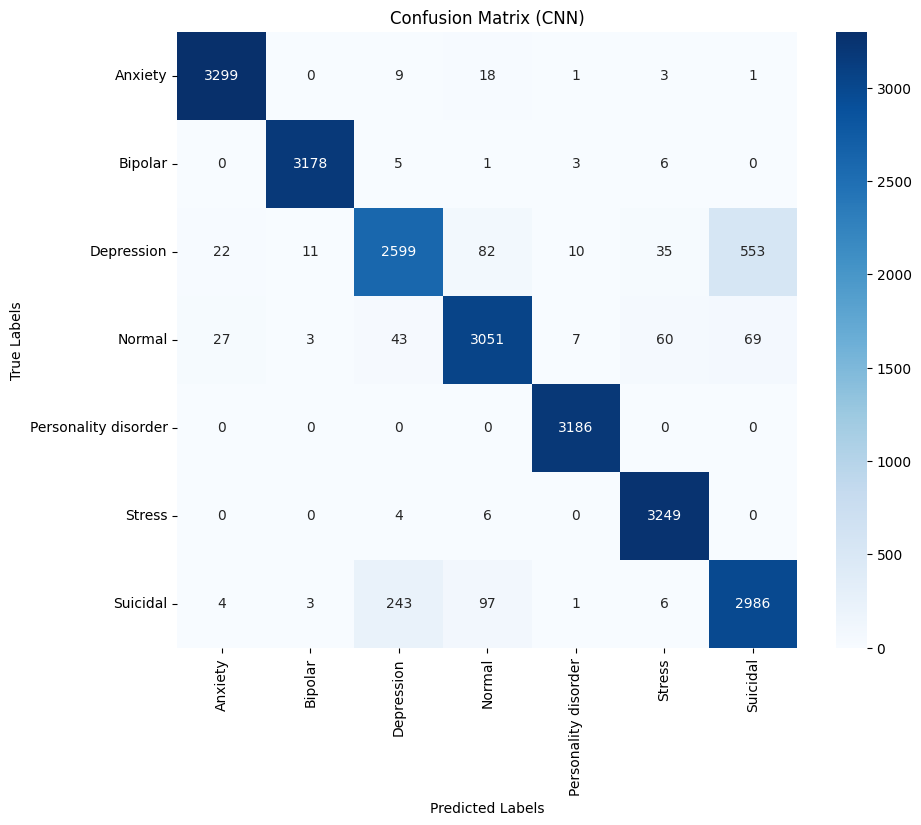

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9842    0.9904    0.9873      3331
             Bipolar     0.9947    0.9953    0.9950      3193
          Depression     0.8953    0.7847    0.8364      3312
              Normal     0.9373    0.9359    0.9366      3260
Personality disorder     0.9931    1.0000    0.9966      3186
              Stress     0.9673    0.9969    0.9819      3259
            Suicidal     0.8274    0.8940    0.8594      3340

            accuracy                         0.9417     22881
           macro avg     0.9427    0.9425    0.9419     22881
        weighted avg     0.9421    0.9417    0.9411     22881



In [18]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (CNN)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


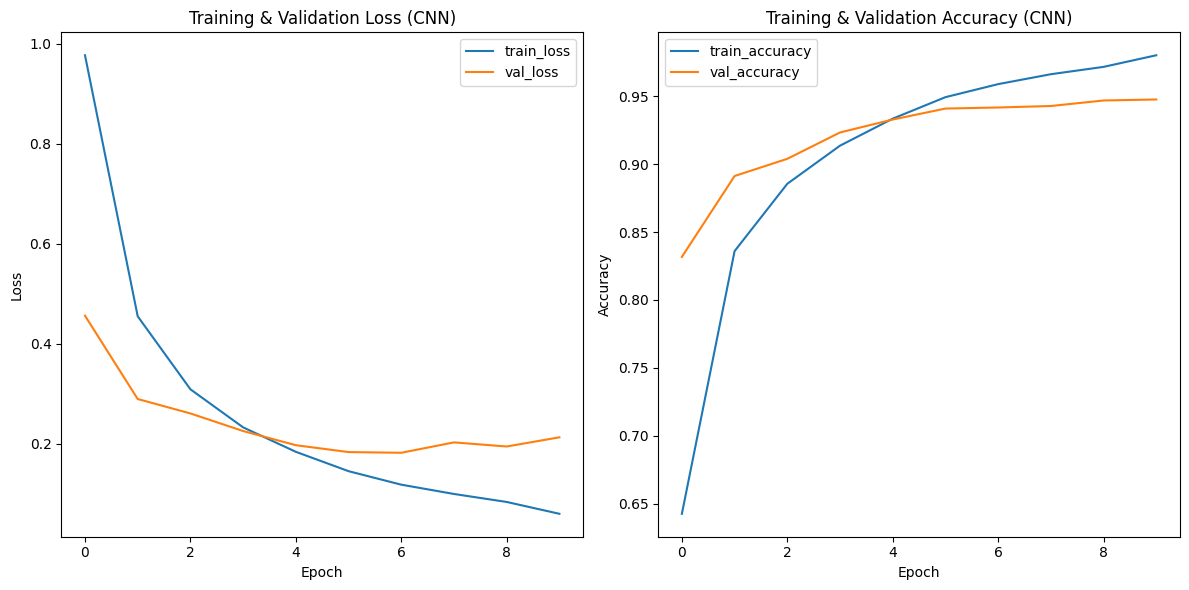

In [19]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

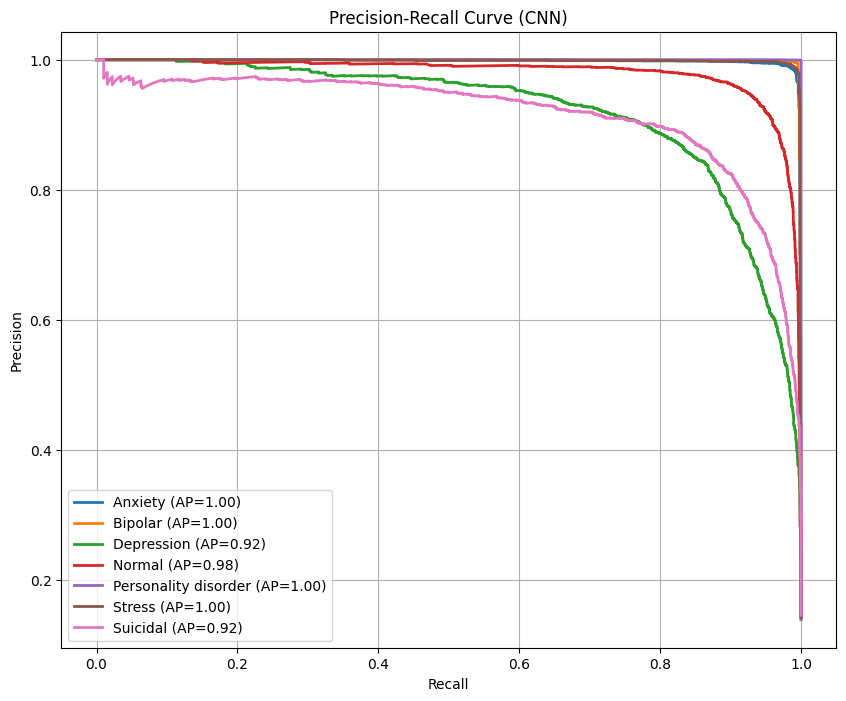

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



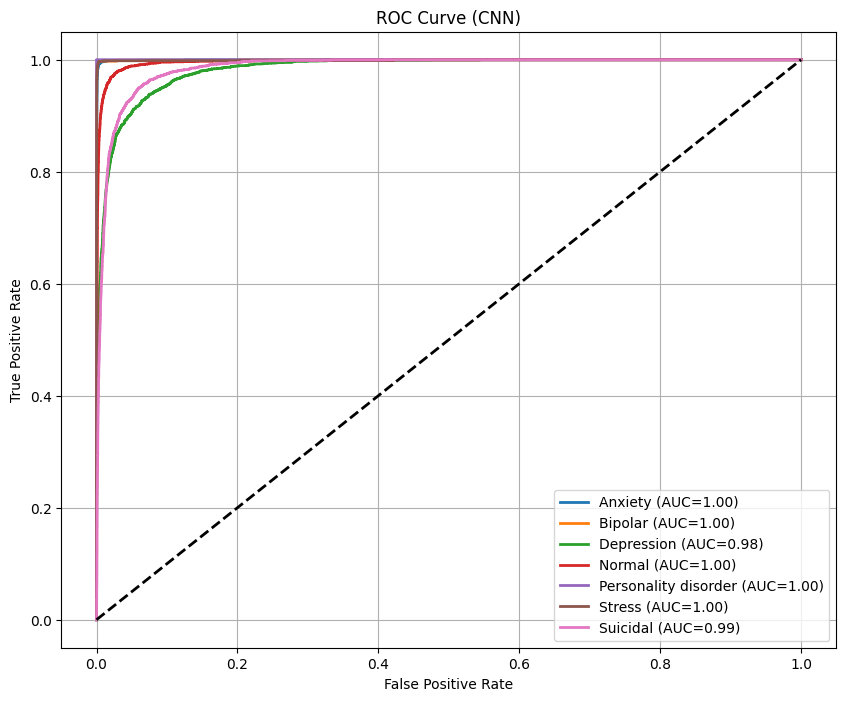

In [21]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
